In [1]:
import scipy.io as matlab_input
import numpy as np
import numpy.linalg as lin
import matplotlib.pyplot as plt
import scipy as sp
import scipy.stats as stats
import scipy.special as functions
import scipy.signal as sig_tools
import autoregressive_simulations as AR
import statsmodels.tsa.vector_ar.var_model as VAR
import random as rnd
from BaNonparConnAnaly import *

%matplotlib inline

/vol/optdcc/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
MEG_signal = matlab_input.loadmat('/vol/actper-scratch1/lucamb/GP_CaKe_MEG_dataset/connectivity_ICA_MEG_signal.mat')
MEG_signal = MEG_signal["MEG_signal"].tolist()
MEG_parameters = matlab_input.loadmat('/vol/actper-scratch1/lucamb/GP_CaKe_MEG_dataset/connectivity_ICA_MEG_parameters.mat')
MEG_parameters = MEG_parameters["MEG_parameters"].tolist()[0]
MEG_parameters = {"amplitude": MEG_parameters[0], "relaxation": MEG_parameters[1], "frequency": MEG_parameters[2]}
MEG_trials_indices = matlab_input.loadmat('/vol/actper-scratch1/lucamb/GP_CaKe_MEG_dataset/connectivity_ICA_MEG_trials_indices.mat')
MEG_trials_indices = MEG_trials_indices["trials_indices"][0]

In [3]:
def list_from_indices(dictionary, indices):
    new_list = []
    for index in indices:
        new_list += [dictionary[index]]
    return new_list

In [4]:
number_trials = len(MEG_signal)
samples = []
for trial_index in range(0, number_trials):
    MEG_index = trial_index #rnd.choice(range(0, number_trials))
    EMG_index = trial_index #rnd.choice(range(0, number_trials))
    MEG_data = MEG_signal[MEG_index][0]
    total_data_1 = np.matrix(MEG_data)[:,0:300]
    total_data_2 = np.matrix(MEG_data)[:,300:600]
    #total_data_3 = np.matrix(stats.mstats.zscore(np.append(MEG_data, EMG_data,0),axis = 1))[:,600:900]
    #total_data_4 = np.matrix(stats.mstats.zscore(np.append(MEG_data, EMG_data,0),axis = 1))[:,900:1200]
    samples += [total_data_1, total_data_2]

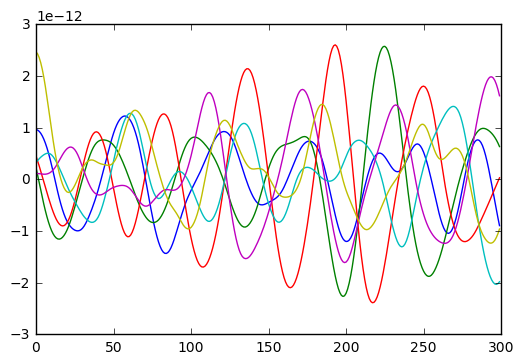

In [5]:
plt.plot(np.transpose(np.array(total_data_1)))

In [6]:
def get_shuffled_samples(samples):
    # rearrange data
    total_list = []
    for index in range(0,samples[0].shape[0]):
        ts_list = []
        for sample in samples:
            ts_list += [sample[index,:]]
        total_list += [ts_list]
    # shuffle lists
    for ts_list in total_list:
        ts_list = np.random.shuffle(ts_list)
    # rearrange lists
    shaffled_samples = []
    for sample_index in range(0, len(samples)):
        for index in range(0,samples[0].shape[0]):
            if index == 0:
                shaffled_array = total_list[index][sample_index]
            else:
                shaffled_array = np.append(shaffled_array, total_list[index][sample_index],axis = 0) 
        shaffled_samples += [shaffled_array]
    return shaffled_samples

-0.00336305393377


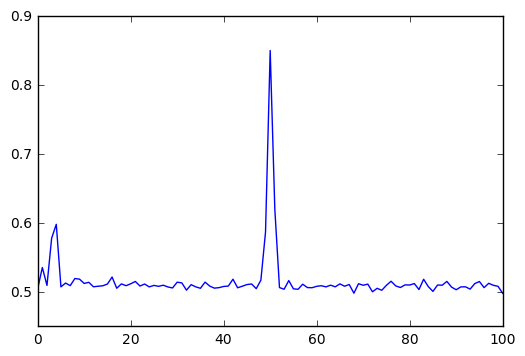

In [7]:
#trial = 0
#plt.plot(np.transpose(np.array(samples[trial][(0,1),:])))
sources = (3,4)
rho = 0.
coh = 0.
for trl in range(0,len(samples)):
    rho += np.corrcoef(np.array(samples[trl][sources,:]))[0,1]/len(samples)
    coh += sig_tools.coherence(np.array(samples[trl][sources[0],:]),
                               np.array(samples[trl][sources[1],:]), 
                               axis = 1, 
                               nperseg=200)[1]/len(samples)
print rho

plt.plot(coh.flatten())

-0.00187666375275


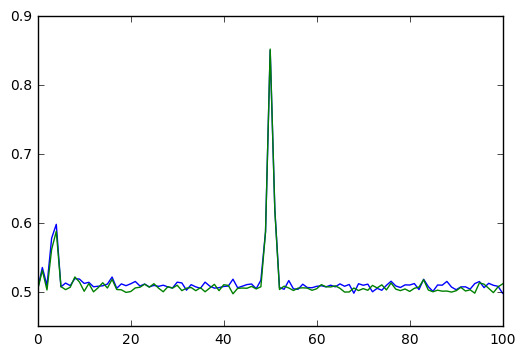

In [8]:
shuffled_samples = get_shuffled_samples(samples)
corr = 0.
shaffle_coh = 0.
for trl in range(0,len(samples)):
    rho = np.corrcoef(np.array(shuffled_samples[trl][sources,:]))[0,1]
    corr += rho/len(samples)
    shaffle_coh += sig_tools.coherence(np.array(shuffled_samples[trl][sources[0],:]),
                               np.array(shuffled_samples[trl][sources[1],:]), 
                               axis = 1, 
                               nperseg=200)[1]/len(samples)
print corr

plt.plot(coh.flatten())
plt.plot(shaffle_coh.flatten())

In [9]:
samples[0].shape

(6, 300)

In [10]:
# test marginal likelihood (dynamic)
jitter = 0.
time_step = 1/600.
time_period = 0.5
MEG_relaxation = MEG_parameters["relaxation"]
MEG_frequency = MEG_parameters["frequency"]
MEG_amplitude = MEG_parameters["amplitude"]
number_sources = 6
GPanalysis = [[],[],[],[],[]]
for condition in range(0,5):
    GPanalysis[condition] = GPconnectivityAnalysis()
    GPanalysis[condition].initialize_time_parameters(time_step, time_period)
    GPanalysis[condition].noise_level = 30. #10
    max_trials = len(MEG_trials_indices[condition])
    condition_samples = list_from_indices(samples, MEG_trials_indices[condition])
    GPanalysis[condition].samples = condition_samples[0:max_trials]
    GPanalysis[condition].dynamic_type = "Oscillation"
    GPanalysis[condition].dynamic_parameters = {"relaxation_constants": number_sources*[MEG_relaxation], 
                                                "frequency": number_sources*[MEG_frequency], 
                                                "amplitude": number_sources*[MEG_amplitude],
                                                "number_sources": number_sources,
                                                "moving_average_time_constants": number_sources*[10**10] }
    GPanalysis[condition].covariance_parameters = {"time_scale": 0.01,
                                                   "time_shift": 0.02,
                                                   "causal": "yes",
                                                   "spectral_smoothing": 40*np.pi*2*10**-1}
    dynamic_type = "Oscillatory"
    GPanalysis[condition].run_analysis()
    GPanalysis[condition].compute_connectivity_statistics()

/vol/optdcc/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


6
6


KeyboardInterrupt: 

/vol/optdcc/anaconda2/lib/python2.7/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/vol/optdcc/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:4645: ComplexWarning: Casting complex values to real discards the imaginary part
  X[0] = start
/vol/optdcc/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:4646: ComplexWarning: Casting complex values to real discards the imaginary part
  X[N + 1] = end
/vol/optdcc/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:4649: ComplexWarning: Casting complex values to real discards the imaginary part
  X[1:N + 1, 1] = y1slice
/vol/optdcc/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:4651: ComplexWarning: Casting complex values to real discards the imaginary part
  X[N + 2:, 1] = y2slice[::-1]


IndexError: list index out of range

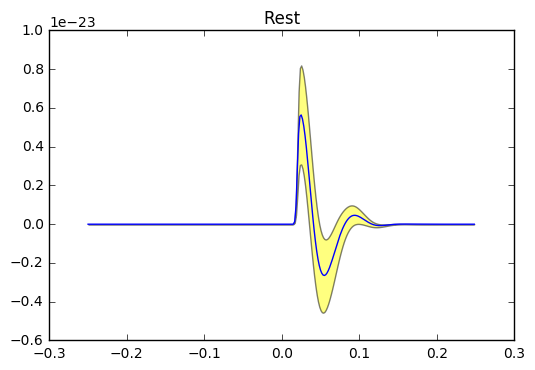

In [11]:
conditions2plot = [0,1,2,3,4]
condition_names = ["Rest","Congruent\Video", "Incongruent\Video", "Congruent\Audio", "Incongruent\Audio"]
input_region = 3
output_region = 0
for condition in conditions2plot:
    GPanalysis[condition].plot_connectivity_statistics(time_range   = GPanalysis[condition].time_parameters["time_range"],
                                                       output_index = output_region, 
                                                       input_index  = input_region,
                                                       error_bars = "95_interval")
    plt.title(condition_names[condition])
    #plt.ylim([4*10**-22, -4*10**-22])

In [ ]:
## test marginal likelihood (dynamic)
#shuffled_samples = get_shuffled_samples(samples)

#shuffled_GPanalysis = GPconnectivityAnalysis()
#shuffled_GPanalysis.initialize_time_parameters(time_step, time_period)
#shuffled_GPanalysis.noise_level = GPanalysis[0].noise_level
#shuffled_GPanalysis.samples = shuffled_samples[0:max_trials]
#shuffled_GPanalysis.dynamic_type = "Oscillation"
#shuffled_GPanalysis.dynamic_parameters = GPanalysis[0].dynamic_parameters
#shuffled_GPanalysis.covariance_parameters = GPanalysis[0].covariance_parameters

#dynamic_type = "Oscillatory"
#shuffled_GPanalysis.run_analysis()
#shuffled_GPanalysis.compute_connectivity_statistics(domain = "time")

# test marginal likelihood (dynamic)
shuffled_GPanalysis = [[],[],[],[],[]]
for condition in range(0,5):
    shuffled_GPanalysis[condition] = GPconnectivityAnalysis()
    shuffled_GPanalysis[condition].initialize_time_parameters(time_step, time_period)
    shuffled_GPanalysis[condition].noise_level = 30. #10
    max_trials = len(MEG_trials_indices[condition])
    condition_samples = list_from_indices(samples, MEG_trials_indices[condition])
    shuffled_condition_samples = get_shuffled_samples(condition_samples)
    shuffled_GPanalysis[condition].samples = shuffled_condition_samples[0:max_trials]
    shuffled_GPanalysis[condition].dynamic_type = "Oscillation"
    shuffled_GPanalysis[condition].dynamic_parameters = {"relaxation_constants": number_sources*[MEG_relaxation], 
                                                "frequency": number_sources*[MEG_frequency], 
                                                "amplitude": number_sources*[MEG_amplitude],
                                                "number_sources": number_sources,
                                                "moving_average_time_constants": number_sources*[10**10] }
    shuffled_GPanalysis[condition].covariance_parameters = {"time_scale": 0.01,
                                                   "time_shift": 0.02,
                                                   "causal": "yes",
                                                   "spectral_smoothing": 40*np.pi*2*10**-1}
    dynamic_type = "Oscillatory"
    shuffled_GPanalysis[condition].run_analysis()
    shuffled_GPanalysis[condition].compute_connectivity_statistics()

In [ ]:
#input_region = 2
#output_region = 0
#shuffled_GPanalysis.plot_connectivity_statistics(data_range   = GPanalysis.time_parameters["time_range"],
#                                                 output_index = output_region, 
#                                                 input_index  = input_region,
#                                                error_bars = "95_interval",
#                                                domain = "time")
#plt.ylim([10**-23*-3, 10**-23*3])

conditions2plot = [0,1,2,3,4]
condition_names = ["Rest","Congruent\Video", "Incongruent\Video", "Congruent\Audio", "Incongruent\Audio"]
for condition in conditions2plot:
    shuffled_GPanalysis[condition].plot_connectivity_statistics(time_range   = shuffled_GPanalysis[condition].time_parameters["time_range"],
                                                       output_index = output_region, 
                                                       input_index  = input_region,
                                                       error_bars = "95_interval")
    plt.title(condition_names[condition])
    #plt.ylim([4*10**-22, -4*10**-22])

In [ ]:
#plt.plot(np.array(samples[0][input_region,:]).flatten())
#plt.plot(np.array(samples[0][output_region,:]).flatten())